In [186]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt

## Load Datasets

In [188]:
# Load road network (OSM)
roads = gpd.read_file("bangkok_roads.geojson")

# Load accident CSV
acc = pd.read_csv("thai_road_accident_2019_2022.csv")
print(acc.columns)

Index(['acc_code', 'incident_datetime', 'report_datetime', 'province_th',
       'province_en', 'agency', 'route', 'vehicle_type', 'presumed_cause',
       'accident_type', 'number_of_vehicles_involved', 'number_of_fatalities',
       'number_of_injuries', 'weather_condition', 'latitude', 'longitude',
       'road_description', 'slope_description'],
      dtype='object')


# Preprocessing

In [189]:
# Convert accidents to GeoDataFrame
acc_gdf = gpd.GeoDataFrame(
    acc,
    geometry=gpd.points_from_xy(acc["longitude"], acc["latitude"]),
    crs="EPSG:4326"
)

# Match coordinate reference systems
roads = roads.to_crs(acc_gdf.crs)

# OSM road type stored in "highway" tag (keep only road features)
roads = roads[roads["highway"].notna()]

In [190]:
acc["incident_datetime"] = pd.to_datetime(acc["incident_datetime"])
acc_2022 = acc[acc["incident_datetime"].dt.year == 2022].copy()

print("Original accidents:", len(acc))
print("2022 accidents:", len(acc_2022))

Original accidents: 81735
2022 accidents: 21032


In [191]:
# Filter to Bangkok bounding box 
# Rough bounding box for Bangkok
bangkok_bounds = {
    "min_lat": 13.5,
    "max_lat": 14.2,
    "min_lon": 100.3,
    "max_lon": 100.9
}

acc_2022 = acc_2022[
    (acc_2022["latitude"] >= bangkok_bounds["min_lat"]) &
    (acc_2022["latitude"] <= bangkok_bounds["max_lat"]) &
    (acc_2022["longitude"] >= bangkok_bounds["min_lon"]) &
    (acc_2022["longitude"] <= bangkok_bounds["max_lon"])
]

print("Bangkok 2022 accidents:", len(acc_2022))

Bangkok 2022 accidents: 3311


In [192]:
# Convert to GeoDataFrame

acc_gdf = gpd.GeoDataFrame(
    acc_2022,
    geometry=gpd.points_from_xy(acc_2022["longitude"], acc_2022["latitude"]),
    crs="EPSG:4326"
)

In [193]:
# Reduce road dataset to bangkok
# Clip roads to accident extents:
roads = gpd.read_file("bangkok_roads.geojson")
roads = roads.to_crs(acc_gdf.crs)

# Clip to bounding box of accidents
roads = roads.cx[
    acc_gdf.total_bounds[0]:acc_gdf.total_bounds[2],
    acc_gdf.total_bounds[1]:acc_gdf.total_bounds[3]
]

In [194]:
# Project to metric CRS before nearest join
acc_proj   = acc_gdf.to_crs(epsg=3857)
roads_proj = roads.to_crs(epsg=3857)

# Analysis
## Heatmaps

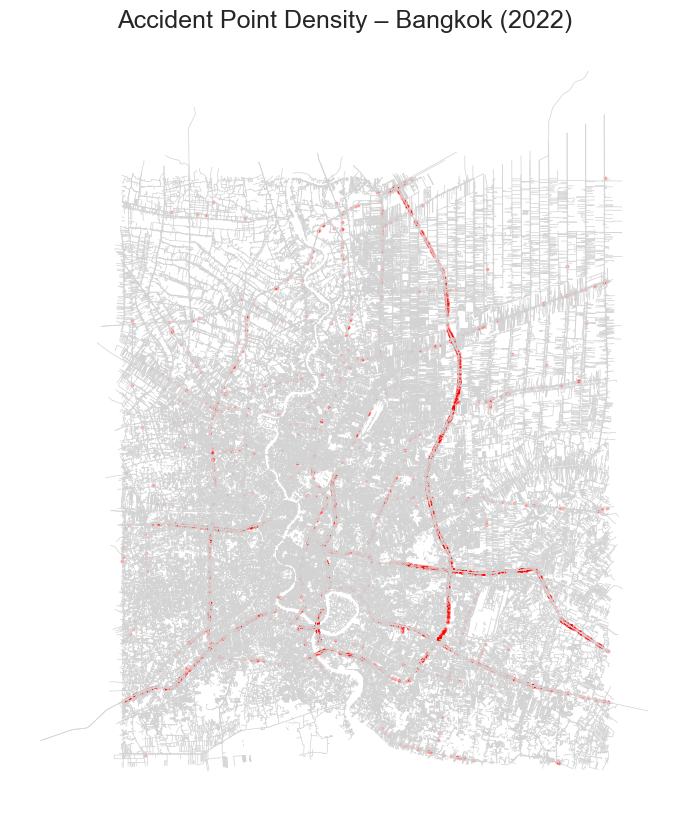

In [195]:
fig, ax = plt.subplots(figsize=(10,10))

roads.plot(ax=ax, color="lightgrey", linewidth=0.5)

acc_gdf.plot(ax=ax, markersize=2, alpha=0.3, color="red")

plt.title("Accident Point Density – Bangkok (2022)")
plt.axis("off")
plt.show()

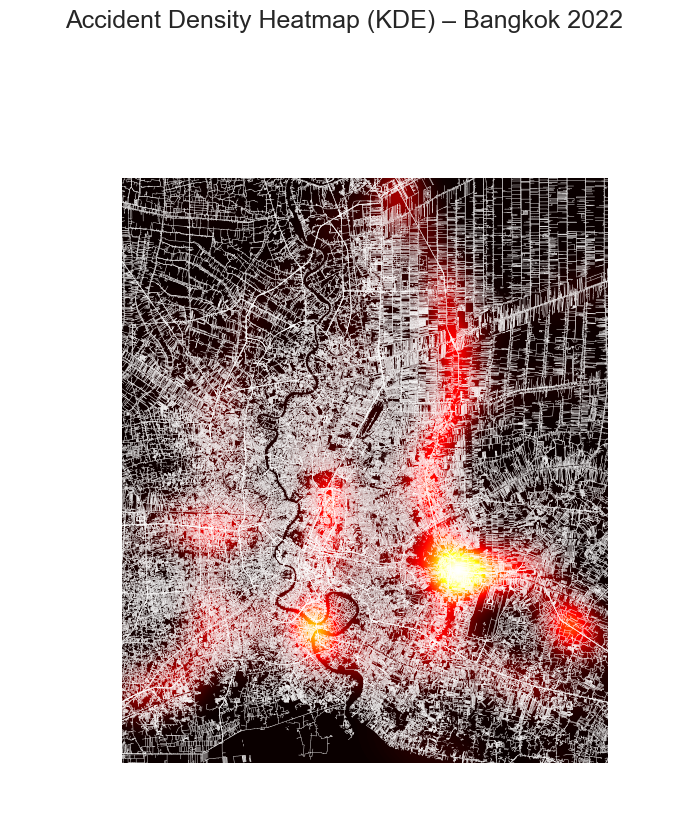

In [196]:
from scipy.stats import gaussian_kde
import numpy as np

# Project to metric CRS for accurate density
acc_proj = acc_gdf.to_crs(epsg=3857)

x = acc_proj.geometry.x
y = acc_proj.geometry.y

# KDE
kde = gaussian_kde([x, y], bw_method=0.15)

# Create grid
xmin, ymin, xmax, ymax = acc_proj.total_bounds
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = np.reshape(kde(positions).T, xx.shape)

# Plot
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(np.rot90(density),
          cmap="hot",
          extent=[xmin, xmax, ymin, ymax])

roads.to_crs(epsg=3857).plot(ax=ax, color="white", linewidth=0.3)
plt.title("Accident Density Heatmap (KDE) – Bangkok 2022")
plt.axis("off")
plt.show()

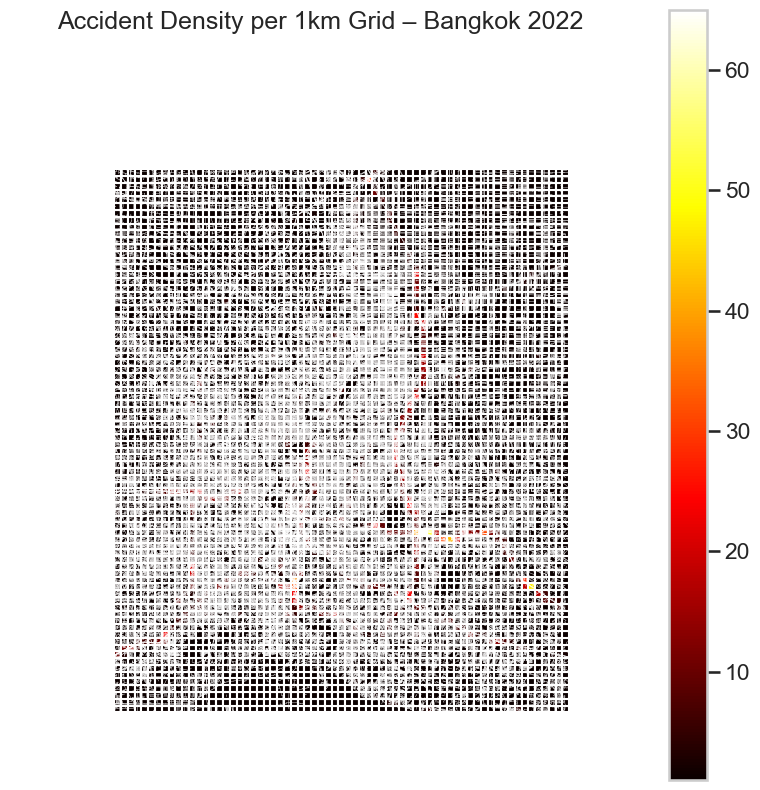

In [197]:
import shapely.geometry as geom

# Build grid
xmin, ymin, xmax, ymax = acc_proj.total_bounds
cell = 1000  # 1 km grid

grid_cells = []
x = xmin
while x < xmax:
    y = ymin
    while y < ymax:
        grid_cells.append(geom.box(x, y, x+cell, y+cell))
        y += cell
    x += cell

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=acc_proj.crs)

# Count accidents per cell
join = gpd.sjoin(grid, acc_proj, how="left")
grid["acc_count"] = join.groupby(level=0).size()

# Plot
fig, ax = plt.subplots(figsize=(10,10))
grid.plot(column="acc_count", cmap="hot", legend=True, ax=ax)
roads.to_crs(epsg=3857).plot(ax=ax, color="white", linewidth=0.3)

plt.title("Accident Density per 1km Grid – Bangkok 2022")
plt.axis("off")
plt.show()

## Severity

In [198]:
def severity_score(row):
    if row["number_of_fatalities"] > 0:
        return 3   # fatal
    elif row["number_of_injuries"] > 0:
        return 2   # injury
    else:
        return 1   # damage only

acc_proj["severity_score"] = acc_proj.apply(severity_score, axis=1)

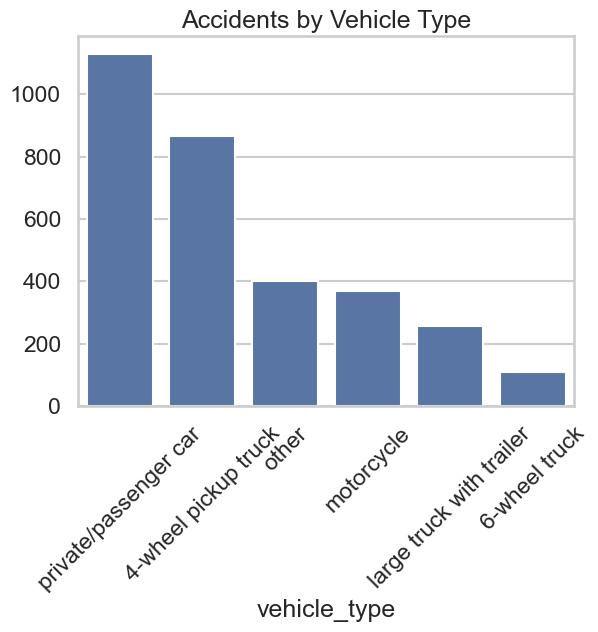

In [199]:
sns.barplot(x=acc_2022["vehicle_type"].value_counts().head(6).index,
            y=acc_2022["vehicle_type"].value_counts().head(6).values)
plt.xticks(rotation=45)
plt.title("Accidents by Vehicle Type")
plt.show()

## Basic Map: Accident locations over roads

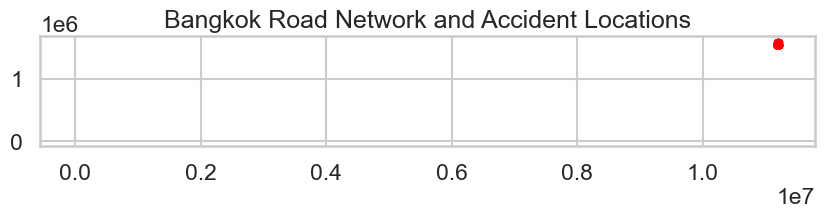

In [200]:
# Assign each accident to nearest road segment 
acc_roads = gpd.sjoin_nearest(acc_proj, roads_proj[["geometry", "highway"]], how="left")

fig, ax = plt.subplots(figsize=(10,10))
roads.plot(ax=ax, color="lightgrey", linewidth=0.5)
acc_roads.plot(ax=ax, color="red", markersize=5)
plt.title("Bangkok Road Network and Accident Locations")
plt.show()

## Bar chart: Accidents by road type

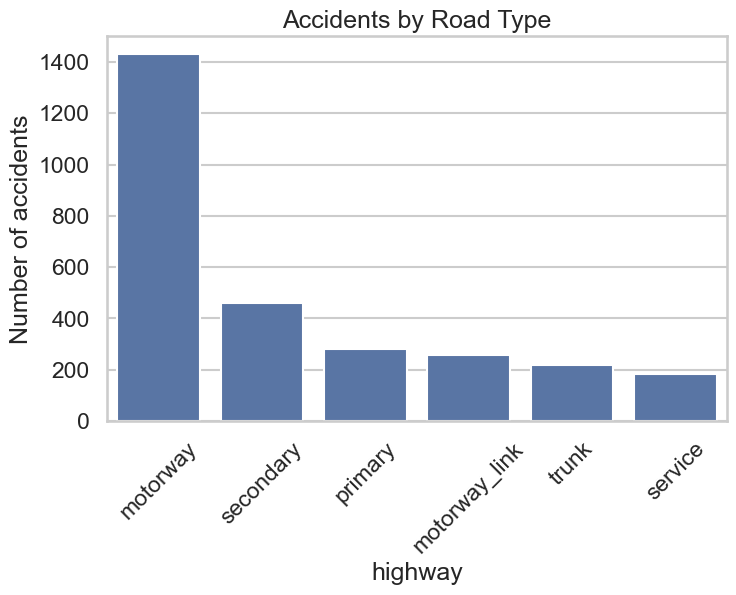

In [201]:
acc_by_type = acc_roads["highway"].value_counts().head(6)

plt.figure(figsize=(8,5))
sns.barplot(x=acc_by_type.index, y=acc_by_type.values)
plt.xticks(rotation=45)
plt.ylabel("Number of accidents")
plt.title("Accidents by Road Type")
plt.show()

## Normalize by road length (accidents per km)

In [ ]:
palette='flare'

/var/folders/zk/s7_stnms693b1vry3z3wr9n40000gn/T/ipykernel_24371/2803875475.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


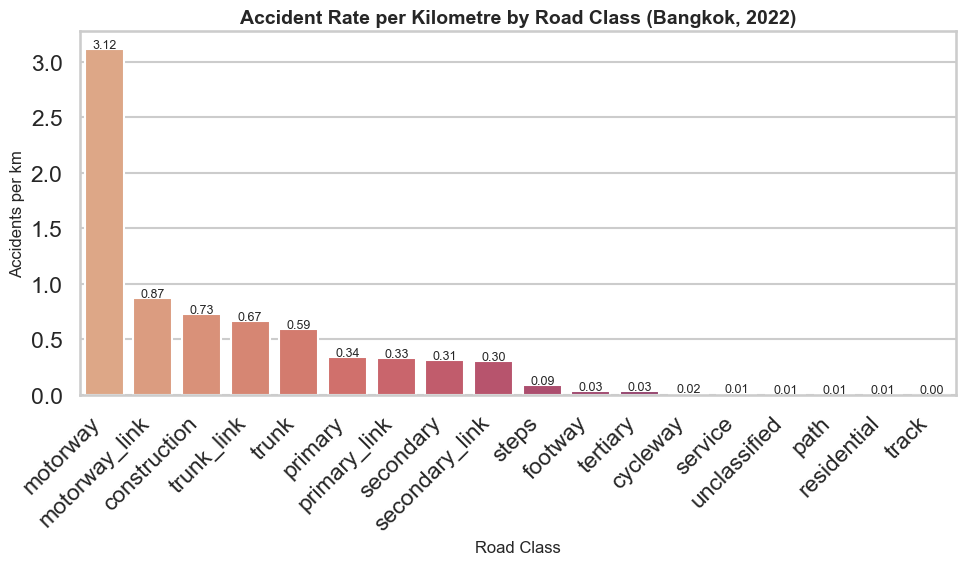

In [225]:


# Compute road lengths in km
roads_proj = roads.to_crs(epsg=3857)   # metric projection
roads_proj["length_km"] = roads_proj.geometry.length / 1000

road_lengths = roads_proj.groupby("highway")["length_km"].sum()

acc_counts = acc_roads.groupby("highway").size()

acc_per_km = (acc_counts / road_lengths).dropna().sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

ax = sns.barplot(
    x=acc_per_km.index,
    y=acc_per_km.values,
    palette="flare"
)

# Add labels above bars
for i, v in enumerate(acc_per_km.values):
    ax.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=9)

# Titles and labels
plt.title("Accident Rate per Kilometre by Road Class (Bangkok, 2022)", fontsize=14, weight="bold")
plt.ylabel("Accidents per km", fontsize=12)
plt.xlabel("Road Class", fontsize=12)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

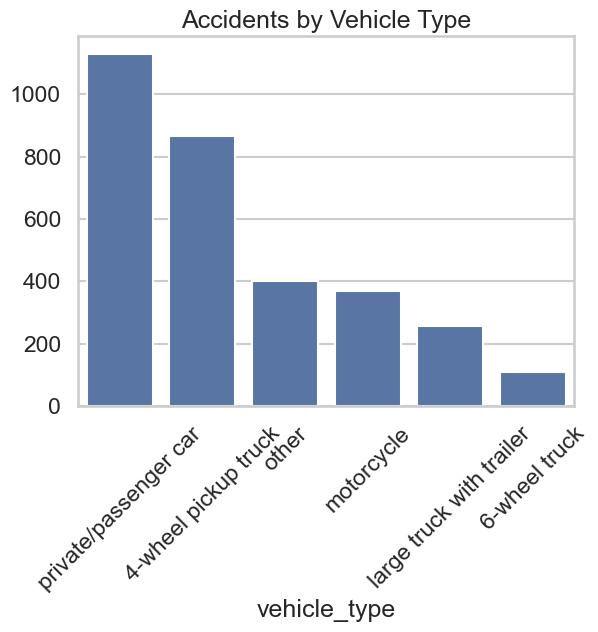

In [203]:
# Weather effect on severity
sns.barplot(x=acc_2022["vehicle_type"].value_counts().head(6).index,
            y=acc_2022["vehicle_type"].value_counts().head(6).values)
plt.xticks(rotation=45)
plt.title("Accidents by Vehicle Type")
plt.show()

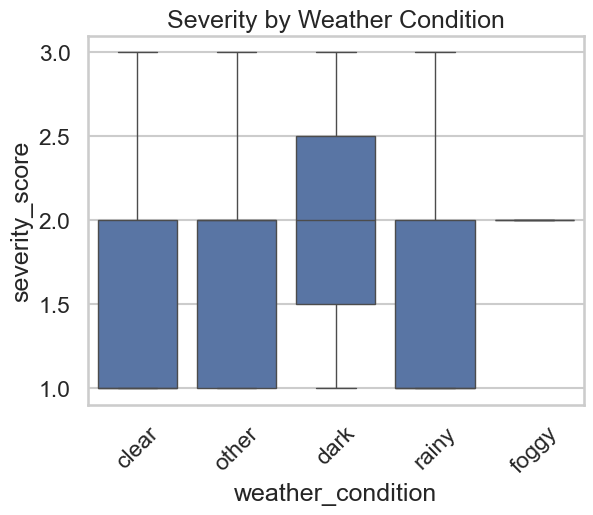

In [205]:
# Road description risk
sns.boxplot(x="weather_condition", y="severity_score", data=acc_roads)
plt.xticks(rotation=45)
plt.title("Severity by Weather Condition")
plt.show()

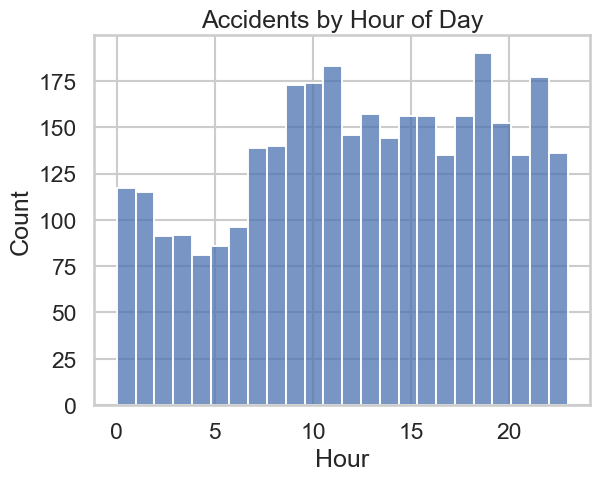

In [207]:
# Time of day pattern

acc_roads["hour"] = acc_roads["incident_datetime"].dt.hour

sns.histplot(acc_roads["hour"], bins=24)
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.show()

## Intersection

In [208]:
# Extract boundary points of each road LineString
junctions = roads_proj.copy()
junctions["geometry"] = junctions.geometry.boundary

# Explode multi-point geometries into individual points
junctions = junctions.explode(index_parts=False)

junctions = junctions[["geometry"]]

In [209]:
# 20 metre radius buffer around each junction
junction_buffer = junctions.buffer(20)

# Combine into a single geometry for fast lookup
junction_union = junction_buffer.union_all()

In [210]:
# flag accidents inside intersection buffer
acc_proj["at_intersection"] = acc_proj.geometry.within(junction_union)

# check result
acc_proj["at_intersection"].value_counts()

at_intersection
False    2553
True      758
Name: count, dtype: int64

## Poisson Regression
What infrastructure predicts accident frequency?
Quantifies how road type and intersections influence accident counts.

In [211]:
# Count accidents per road segment
road_acc_counts = acc_roads.groupby("index_right").size()

roads_proj["acc_count"] = road_acc_counts
roads_proj["acc_count"] = roads_proj["acc_count"].fillna(0)

# Road length (exposure variable)
roads_proj["length_km"] = roads_proj.geometry.length / 1000

In [212]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = roads_proj[["acc_count","length_km","highway"]].copy()
df["log_length"] = np.log(df["length_km"] + 0.001)

model = smf.glm(
    formula="acc_count ~ C(highway)",
    data=df,
    family=sm.families.Poisson(),
    offset=df["log_length"]
).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              acc_count   No. Observations:               435447
Model:                            GLM   Df Residuals:                   435420
Model Family:                 Poisson   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9753.6
Date:                Wed, 21 Jan 2026   Deviance:                       16071.
Time:                        17:46:34   Pearson chi2:                 2.05e+06
No. Iterations:                    22   Pseudo R-squ. (CS):            0.03542
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## Ordinal Logistic Regression
What predicts accident severity?
Which factors increase probability of fatal vs minor accidents.

In [213]:
# from mord import LogisticAT

# # Build feature table
# X = acc_roads[["at_intersection"]].copy()

# # One-hot encode road type
# X = pd.get_dummies(acc_roads["highway"], prefix="road")
# X["intersection"] = acc_roads["at_intersection"].astype(int)

# y = acc_roads["severity_score"]

# model = LogisticAT()
# model.fit(X, y)

# print("Model fitted")

In [214]:
# print(model.coef_)

## Temporal Pattern Decomposition
Daily accident rhythm.

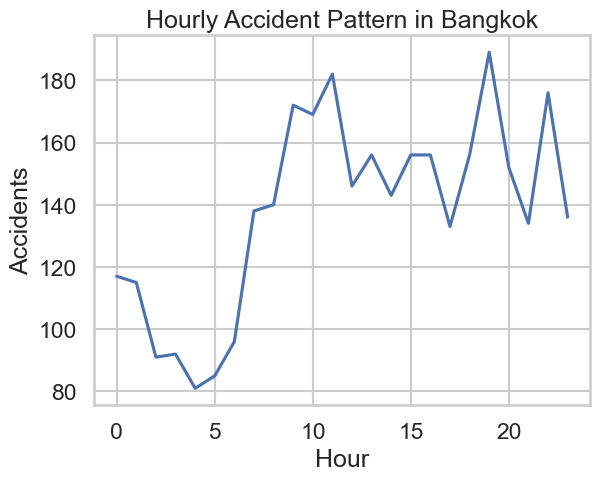

In [215]:
acc_2022["hour"] = acc_2022["incident_datetime"].dt.hour

hourly = acc_2022.groupby("hour").size()

plt.plot(hourly.index, hourly.values)
plt.xlabel("Hour")
plt.ylabel("Accidents")
plt.title("Hourly Accident Pattern in Bangkok")
plt.show()

## Association Rule Mining 
Common accident conditions

In [216]:
from mlxtend.frequent_patterns import apriori, association_rules

# Build basket-style table
basket = acc_2022[["vehicle_type","weather_condition","road_description"]]
basket = pd.get_dummies(basket)

freq = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(freq, metric="confidence", min_threshold=0.6)

rules.sort_values("lift", ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
28,(vehicle_type_private/passenger car),"(road_description_straight road, weather_condi...",0.341287,0.767744,0.284204,0.832743,1.084663,1.0,0.022183,1.388621,0.118496,0.344562,0.279861,0.601462
9,(vehicle_type_private/passenger car),(road_description_straight road),0.341287,0.836907,0.304742,0.892920,1.066929,1.0,0.019117,1.523097,0.095231,0.348893,0.343443,0.628524
27,"(weather_condition_clear, vehicle_type_private...",(road_description_straight road),0.318333,0.836907,0.284204,0.892789,1.066772,1.0,0.017789,1.521237,0.091823,0.326283,0.342640,0.616189
4,(vehicle_type_motorcycle),(weather_condition_clear),0.111145,0.909393,0.106614,0.959239,1.054813,1.0,0.005540,2.222893,0.058462,0.116656,0.550136,0.538238
20,"(road_description_straight road, vehicle_type_...",(weather_condition_clear),0.087285,0.909393,0.083359,0.955017,1.050170,1.0,0.003982,2.014265,0.052342,0.091270,0.503541,0.523341


## Clustering 
Distinct accident profiles

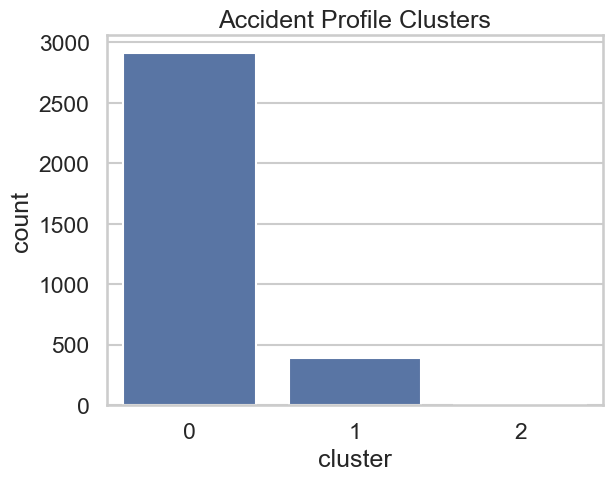

In [217]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = acc_2022[["number_of_vehicles_involved",
                     "number_of_injuries",
                     "number_of_fatalities"]]

X = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
acc_2022["cluster"] = kmeans.fit_predict(X)

sns.countplot(x="cluster", data=acc_2022)
plt.title("Accident Profile Clusters")
plt.show()

## Predictive Model
Can you predict severity?
Simple random forest

In [235]:
print(acc_proj.columns)

Index(['acc_code', 'incident_datetime', 'report_datetime', 'province_th',
       'province_en', 'agency', 'route', 'vehicle_type', 'presumed_cause',
       'accident_type', 'number_of_vehicles_involved', 'number_of_fatalities',
       'number_of_injuries', 'weather_condition', 'latitude', 'longitude',
       'road_description', 'slope_description', 'geometry', 'severity_score',
       'at_intersection'],
      dtype='object')


In [251]:
acc_final = acc_roads.copy()

required_cols = ["severity_score","road_class","at_intersection"]
print("Missing columns:", [c for c in required_cols if c not in acc_final.columns])

Missing columns: []


In [252]:
roads = roads.rename(columns={"highway": "road_class"})
roads = roads[["geometry", "road_class"]]
roads = roads.set_crs(epsg=4326)

acc_roads = gpd.sjoin_nearest(
    acc_proj,
    acc_final[["geometry", "highway"]],  # <- explicitly include road_class
    how="left"
)

print(acc_roads.columns)

Index(['acc_code', 'incident_datetime', 'report_datetime', 'province_th',
       'province_en', 'agency', 'route', 'vehicle_type', 'presumed_cause',
       'accident_type', 'number_of_vehicles_involved', 'number_of_fatalities',
       'number_of_injuries', 'weather_condition', 'latitude', 'longitude',
       'road_description', 'slope_description', 'geometry', 'severity_score',
       'at_intersection', 'index_right', 'highway'],
      dtype='object')


In [ ]:
major_roads = ["motorway","trunk","primary","secondary"]
minor = ["tertiary", "residential", "service", "unclassified", "track", "path", "cycleway", "footway", "steps"]

acc_final["major_roads"] = acc_final["highway"].isin(
    ["motorway","trunk","primary","secondary"]
).astype(int)
acc_roads["minor"] = (~acc_roads["highway"].isin(major_roads)).astype(int)

acc_roads["road_class"] = acc_roads["highway"].apply(
    lambda x: x if x in major_roads else "other"
)
8``# sanity check
print(acc_roads["highway"].value_counts())

highway
motorway          9019
secondary          555
motorway_link      545
trunk_link         442
primary            370
trunk              313
service            245
residential        207
construction       205
footway            177
secondary_link      75
primary_link        55
tertiary            53
unclassified        30
path                 4
cycleway             3
steps                3
track                2
Name: count, dtype: int64


In [254]:
features = pd.get_dummies(acc_roads["road_class"], prefix="road")
features["intersection"] = acc_roads["at_intersection"].astype(int)

X_road = features
y_road = acc_roads["severity_score"]

In [257]:
df = acc_roads[["acc_count","length_km","highway"]].copy()
df["log_length"] = np.log(df["length_km"] + 0.001)

model = smf.glm(
    formula="acc_count ~ C(road_class)",
    data=df,
    family=sm.families.Poisson(),
    offset=df["log_length"]
).fit()

print(model.summary())

KeyError: "['acc_count', 'length_km'] not in index"

In [ ]:
print(acc_proj["severity_score"].value_counts())

severity_score
1    1958
2    1211
3     142
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_road, y, test_size=0.3, random_state=42
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.59      0.92      0.71       567
           2       0.48      0.14      0.22       382
           3       0.00      0.00      0.00        50

    accuracy                           0.57       999
   macro avg       0.36      0.35      0.31       999
weighted avg       0.52      0.57      0.49       999



/Users/syephasuk/Documents/Warwick Msc ComSci/Data Analytics CS910/Coursework Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/syephasuk/Documents/Warwick Msc ComSci/Data Analytics CS910/Coursework Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/syephasuk/Documents/Warwick Msc ComSci/Data Analytics CS910/Coursework Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision 

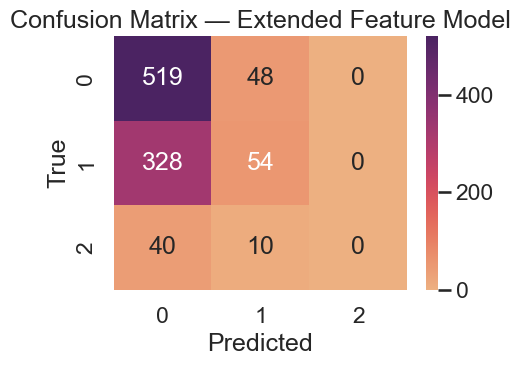

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare")
plt.title("Confusion Matrix — Extended Feature Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# Build series
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

# Use same palette as before (replace with your palette variable if you have one)
palette = plt.cm.Set2.colors   # or your previously used palette list

# Create figure
plt.figure(figsize=(8, 6))

bars = plt.barh(importances.index, importances.values,
                color=palette[:len(importances)],
                edgecolor="white",
                linewidth=0.8)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, 
             bar.get_y() + bar.get_height()/2,
             f"{width:.3f}",
             va='center',
             fontsize=9)

# Styling
plt.title("Feature Importance in Severity Classification", fontsize=14, pad=12)
plt.xlabel("Importance Score", fontsize=11)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

ValueError: Length of values (8) does not match length of index (6)

## Extended Feature Explatory Analysis

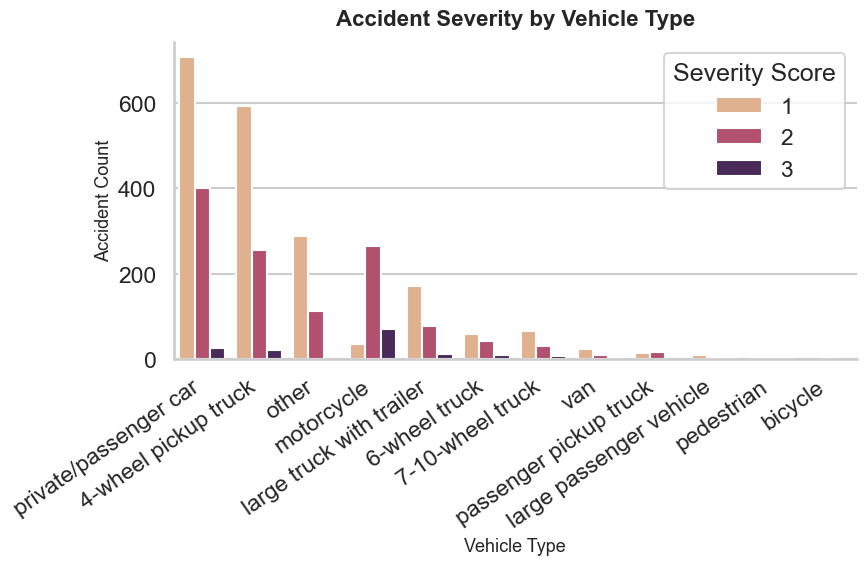

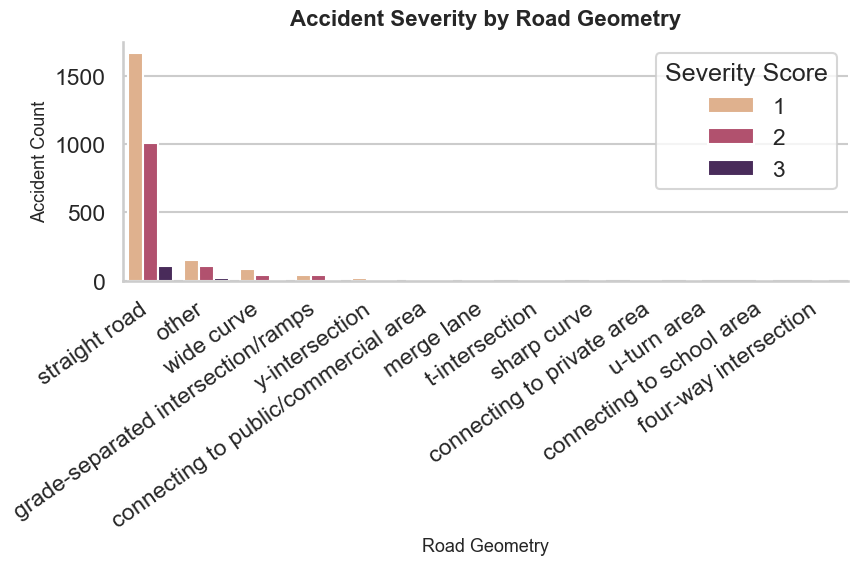

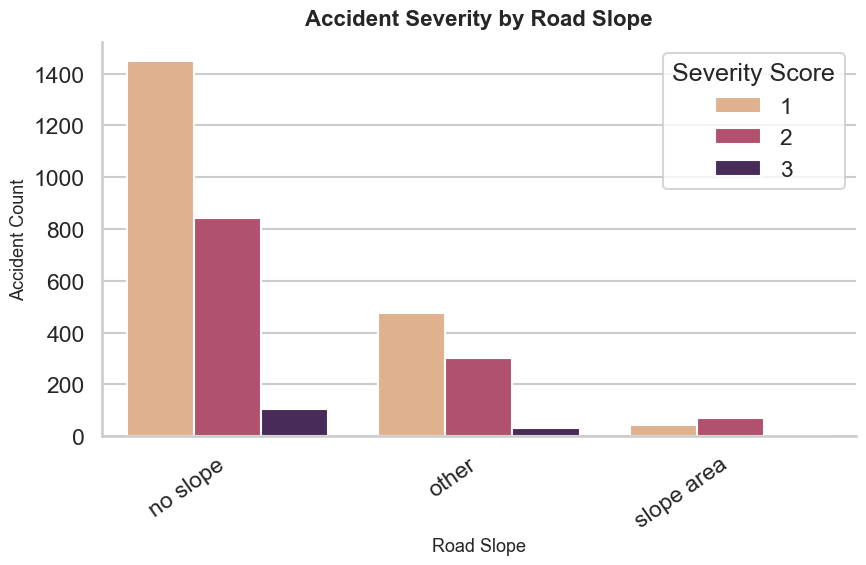

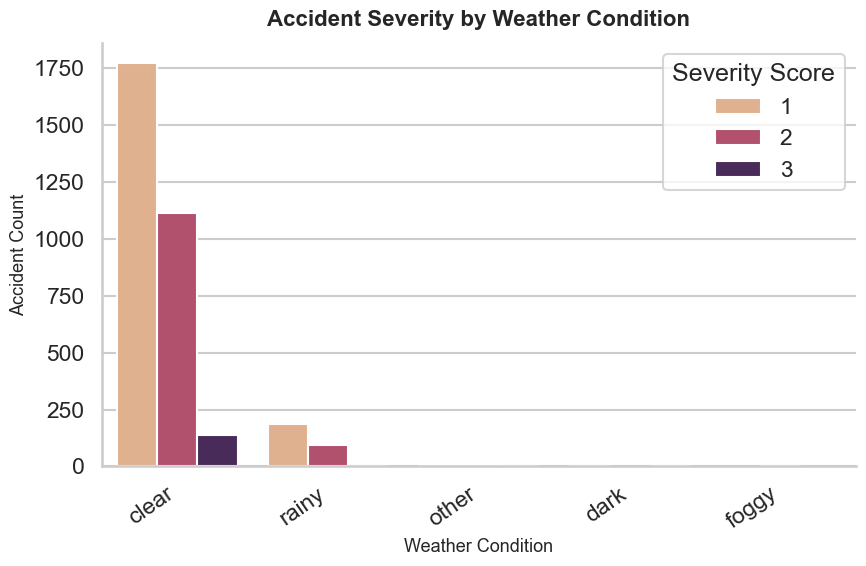

In [ ]:

# Global styling
sns.set_theme(style="whitegrid", context="talk")
palette = "pink"   # soft professional colors

def pretty_countplot(data, x, hue, title, xlabel):
    plt.figure(figsize=(9,6))
    
    # Order categories by total frequency for cleaner layout
    order = data[x].value_counts().index
    
    ax = sns.countplot(
        data=data,
        x=x,
        hue=hue,
        order=order,
        palette="flare"
    )
    
    ax.set_title(title, fontsize=16, weight="bold", pad=12)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel("Accident Count", fontsize=13)
    
    plt.xticks(rotation=35, ha="right")
    plt.legend(title="Severity Score", frameon=True)
    sns.despine()
    
    plt.tight_layout()
    plt.show()


pretty_countplot(acc_roads, 
                 x="vehicle_type",
                 hue="severity_score",
                 title="Accident Severity by Vehicle Type",
                 xlabel="Vehicle Type")

pretty_countplot(acc_roads, 
                 x="road_description",
                 hue="severity_score",
                 title="Accident Severity by Road Geometry",
                 xlabel="Road Geometry")

pretty_countplot(acc_roads, 
                 x="slope_description",
                 hue="severity_score",
                 title="Accident Severity by Road Slope",
                 xlabel="Road Slope")

pretty_countplot(acc_roads, 
                 x="weather_condition",
                 hue="severity_score",
                 title="Accident Severity by Weather Condition",
                 xlabel="Weather Condition")

## Random Forest Model 2

In [ ]:
features_extended = [
    "road_class",
    "at_intersection",
    "weather_condition",
    "vehicle_type",
    "road_description",
    "slope_description"
]

X = acc_roads[features_extended]
y = acc_roads["severity_score"]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = X.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

rf_extended = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight="balanced"   # helps severity imbalance
    ))
])

rf_extended.fit(X_train_full, y_train_full)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sp

              precision    recall  f1-score   support

           1       0.69      0.66      0.68       394
           2       0.46      0.36      0.40       243
           3       0.11      0.34      0.16        29

    accuracy                           0.54       666
   macro avg       0.42      0.46      0.41       666
weighted avg       0.58      0.54      0.55       666



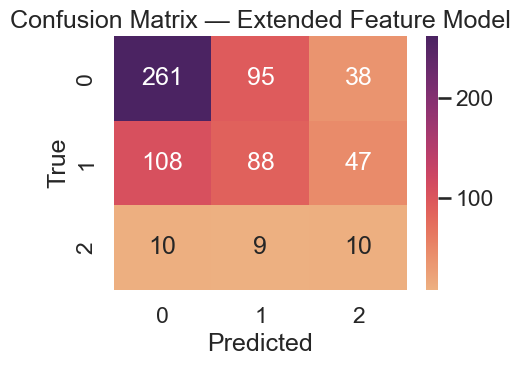

In [ ]:


y_pred_full = rf_extended.predict(X_test_full)

print(classification_report(y_test_full, y_pred_full))

cm = confusion_matrix(y_test_full, y_pred_full)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare")
plt.title("Confusion Matrix — Extended Feature Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# Get trained random forest
rf_model = rf_extended.named_steps["classifier"]

# Get one-hot feature names
ohe = rf_extended.named_steps["preprocessor"].named_transformers_["cat"]
feature_names = ohe.get_feature_names_out(categorical_features)

# Importance values
importances = pd.Series(rf_model.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=True)

/var/folders/zk/s7_stnms693b1vry3z3wr9n40000gn/T/ipykernel_24371/4106993622.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="flare")


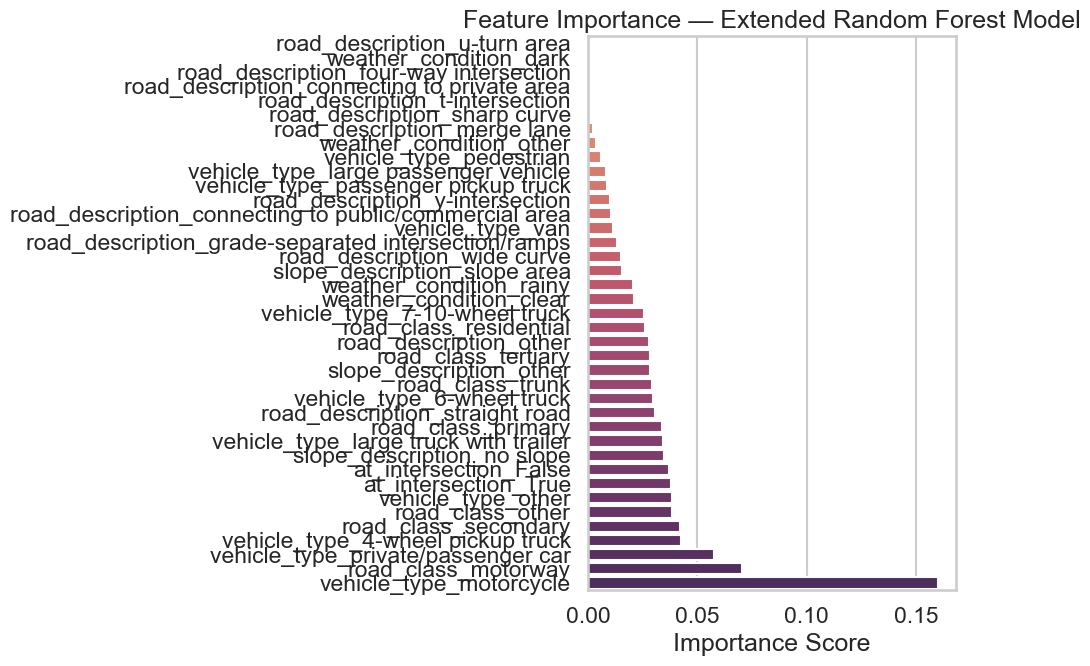

In [ ]:
plt.figure(figsize=(10,7))
sns.barplot(x=importances.values, y=importances.index, palette="flare")
plt.title("Feature Importance — Extended Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

## Compare Model 1 and 2

In [ ]:
from sklearn.metrics import accuracy_score

acc_road_only = accuracy_score(y_test, rf.predict(X_test))
acc_extended  = accuracy_score(y_test_full, y_pred_full)

print(f"Road-only model accuracy: {acc_road_only:.3f}")
print(f"Extended model accuracy:  {acc_extended:.3f}")

Road-only model accuracy: 0.574
Extended model accuracy:  0.539


In [ ]:
from sklearn.model_selection import cross_val_score

cv_road = cross_val_score(rf, X_road, y, cv=5).mean()
cv_ext  = cross_val_score(rf_extended, X, y, cv=5).mean()

print(f"CV Accuracy Road-only: {cv_road:.3f}")
print(f"CV Accuracy Extended:  {cv_ext:.3f}")

CV Accuracy Road-only: 0.599
CV Accuracy Extended:  0.553
